In [1]:
import os
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define paths
train_dir = r'C:\Users\Shashank Mahato\Desktop\Semester-8\Project Phase-2\7-smaller-split-augmented data\train'
val_dir = r'C:\Users\Shashank Mahato\Desktop\Semester-8\Project Phase-2\7-smaller-split-augmented data\val'
test_dir = r'C:\Users\Shashank Mahato\Desktop\Semester-8\Project Phase-2\7-smaller-split-augmented data\test'
model_save_dir = r'C:\Users\Shashank Mahato\Desktop\Semester-8\Project Phase-2\7-codes-smaller-split-augmented data\Saved-models'

# Prepare the data
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False)

# Load MobileNet model pre-trained on ImageNet
base_model = tf.keras.applications.ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze the base model
base_model.trainable = False

# Create new model on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(7, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Ensure model save directory exists
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)

Found 5600 images belonging to 7 classes.
Found 700 images belonging to 7 classes.


In [2]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
)

Epoch 1/50


c:\Users\Shashank Mahato\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


175/175 ━━━━━━━━━━━━━━━━━━━━ 221s 1s/step - accuracy: 0.2077 - loss: 2.0037 - val_accuracy: 0.2783 - val_loss: 1.8391
Epoch 2/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 212s 1s/step - accuracy: 0.3007 - loss: 1.7447 - val_accuracy: 0.3170 - val_loss: 1.7764
Epoch 3/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.3240 - loss: 1.7057 - val_accuracy: 0.3646 - val_loss: 1.6390
Epoch 4/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - accuracy: 0.3747 - loss: 1.6260 - val_accuracy: 0.3914 - val_loss: 1.6296
Epoch 5/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 337s 2s/step - accuracy: 0.3966 - loss: 1.5715 - val_accuracy: 0.3140 - val_loss: 1.6976
Epoch 6/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 241s 1s/step - accuracy: 0.4263 - loss: 1.5095 - val_accuracy: 0.3527 - val_loss: 1.6667
Epoch 7/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 241s 1s/step - accuracy: 0.4321 - loss: 1.5025 - val_accuracy: 0.4003 - val_loss: 1.5363
Epoch 8/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 254s 1s/step - accuracy: 0.4384 - loss: 1.4674 - val_accuracy: 0.382

In [3]:
final_val_accuracy = history.history['val_accuracy'][-1]
print(f'Final Validation Accuracy: {final_val_accuracy*100:.2f}%')

Final Validation Accuracy: 53.12%


In [4]:
# Save the model
model_save_path = os.path.join(model_save_dir, 'ResNet50_model.h5')
model.save(model_save_path)

In [5]:
# Evaluate on test set
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False)

test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc*100:.2f}%")


Found 700 images belonging to 7 classes.
22/22 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.5507 - loss: 1.1809
Test Accuracy: 51.71%


22/22 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step


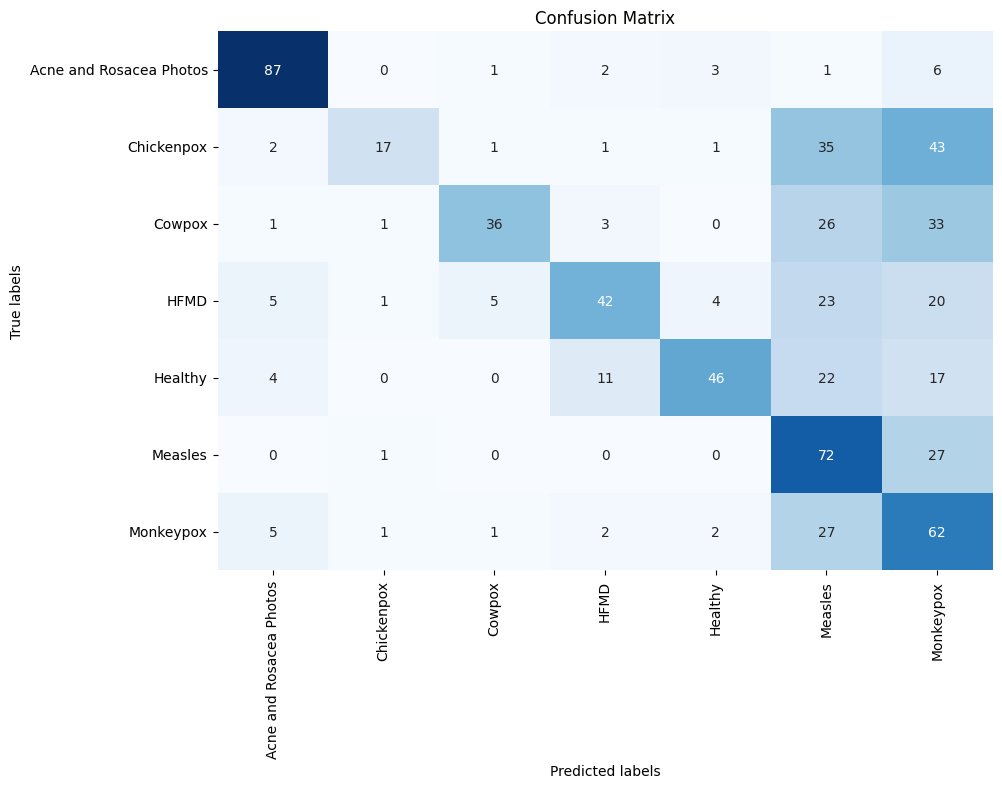

In [6]:
# Predict the data (for confusion matrix)
test_generator.reset()  # Ensure the generator is reset before prediction
predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

# Confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
class_labels = list(test_generator.class_indices.keys())

# Visualizing the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False,
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [7]:
# Classification Report
print('\nClassification Report')
report = classification_report(true_classes, predicted_classes, target_names=list(test_generator.class_indices.keys()))
print(report)


Classification Report
                         precision    recall  f1-score   support

Acne and Rosacea Photos       0.84      0.87      0.85       100
             Chickenpox       0.81      0.17      0.28       100
                 Cowpox       0.82      0.36      0.50       100
                   HFMD       0.69      0.42      0.52       100
                Healthy       0.82      0.46      0.59       100
                Measles       0.35      0.72      0.47       100
              Monkeypox       0.30      0.62      0.40       100

               accuracy                           0.52       700
              macro avg       0.66      0.52      0.52       700
           weighted avg       0.66      0.52      0.52       700



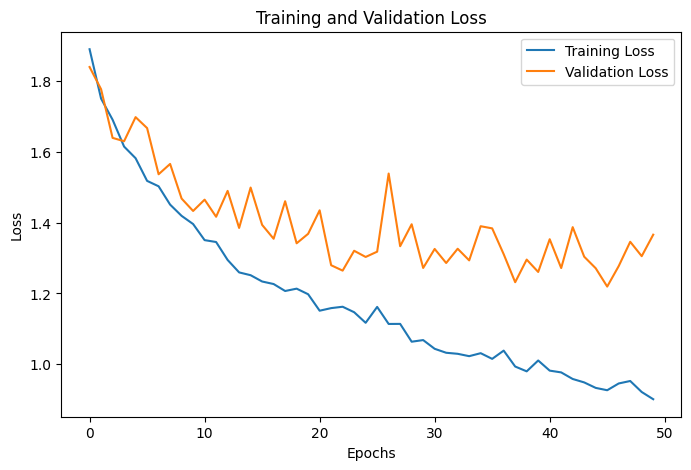

In [8]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()